In [1]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

In [2]:
device = "cuda"
epochs = 300
batch_size = 128

In [3]:
LOAD_CHECKPOINT = True
CHECKPOINT_NAME = "SIG-60-SimCLR-140.pt"

DATASET = "sig60"

if DATASET == "badnets":
    TARGET_CLASS = 1
elif DATASET == "wanet":
    TARGET_CLASS = 0
elif DATASET == "sig":
    TARGET_CLASS = 0
elif DATASET == "sig60":
    TARGET_CLASS = 0
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [4]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)

if DATASET == "badnets":
    poison_dataset = BadNetsDataset(dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
elif DATASET == "wanet":
    poison_dataset = WaNetDataset(dataset, TARGET_CLASS, seed=1)
elif DATASET == "sig":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=1)
elif DATASET == "sig60":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, alpha=0.6, seed=2)
else:
    raise Exception("Invalid dataset")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## SimCLR data augmentations

In [5]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [6]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [7]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [8]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [9]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

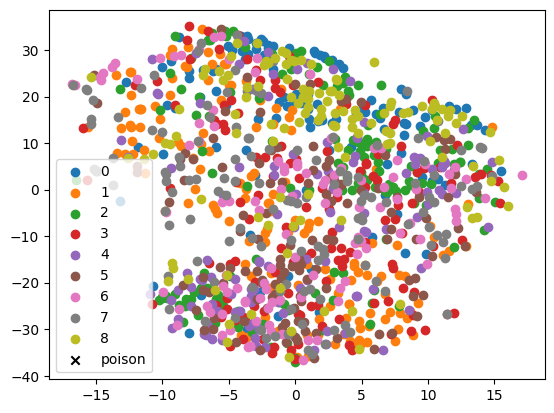

In [10]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true[:]
    labels[[poison_dataset.is_poison(i) for i in range(len(labels))]] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [11]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [12]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [13]:
start_epoch = 0

load_checkpoint = False
checkpoint_name = "WaNet-SimCLR_150.pt"

if LOAD_CHECKPOINT:
    out = os.path.join('./saved_models/', CHECKPOINT_NAME)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [0/300]	


C:\Users\Luka\AppData\Local\Temp\ipykernel_13204\1065139194.py:129: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1519.)
  next_v.mul_(momentum).add_(scaled_lr, grad)


	Step [0/391]	 Loss: 5.22204
	Step [50/391]	 Loss: 4.49135
	Step [100/391]	 Loss: 4.11756
	Step [150/391]	 Loss: 3.93442
	Step [200/391]	 Loss: 3.91704
	Step [250/391]	 Loss: 3.85757
	Step [300/391]	 Loss: 3.82973
	Step [350/391]	 Loss: 3.81209

	Training Loss: 4.06206760930893
	Time Taken: 4.271873287359873 minutes
	Saved model, optimizer, scheduler and epoch info to ./saved_models/NEW-SimCLR.pt


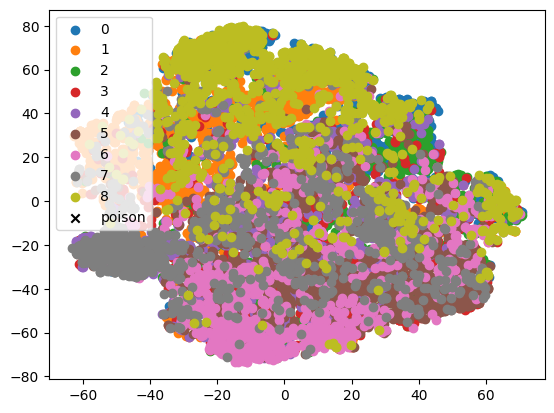

Epoch [1/300]	
	Step [0/391]	 Loss: 3.78919
	Step [50/391]	 Loss: 3.78621
	Step [100/391]	 Loss: 3.75396
	Step [150/391]	 Loss: 3.77359
	Step [200/391]	 Loss: 3.75725
	Step [250/391]	 Loss: 3.76727
	Step [300/391]	 Loss: 3.75351
	Step [350/391]	 Loss: 3.7659

	Training Loss: 3.7684641116110567
	Time Taken: 3.622397824128469 minutes
Epoch [2/300]	
	Step [0/391]	 Loss: 3.74484
	Step [50/391]	 Loss: 3.75375
	Step [100/391]	 Loss: 3.74701
	Step [150/391]	 Loss: 3.78851
	Step [200/391]	 Loss: 3.74683
	Step [250/391]	 Loss: 3.7409
	Step [300/391]	 Loss: 3.73658
	Step [350/391]	 Loss: 3.73577

	Training Loss: 3.7496179723373766
	Time Taken: 3.6302144567171735 minutes
Epoch [3/300]	
	Step [0/391]	 Loss: 3.72471
	Step [50/391]	 Loss: 3.73015
	Step [100/391]	 Loss: 3.738
	Step [150/391]	 Loss: 3.73995
	Step [200/391]	 Loss: 3.72595
	Step [250/391]	 Loss: 3.73909
	Step [300/391]	 Loss: 3.73255
	Step [350/391]	 Loss: 3.72965

	Training Loss: 3.7328293201563607
	Time Taken: 3.616231302420298 minute

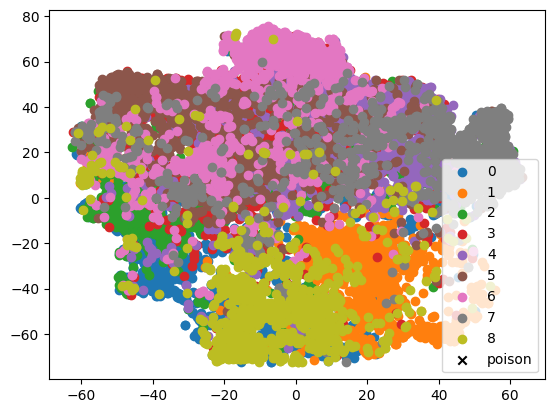

Epoch [11/300]	
	Step [0/391]	 Loss: 3.66737
	Step [50/391]	 Loss: 3.67272
	Step [100/391]	 Loss: 3.6678
	Step [150/391]	 Loss: 3.66647
	Step [200/391]	 Loss: 3.67348
	Step [250/391]	 Loss: 3.67271
	Step [300/391]	 Loss: 3.66908
	Step [350/391]	 Loss: 3.6813

	Training Loss: 3.668354129547353
	Time Taken: 3.6263151009877523 minutes
Epoch [12/300]	
	Step [0/391]	 Loss: 3.65764
	Step [50/391]	 Loss: 3.66715
	Step [100/391]	 Loss: 3.67666
	Step [150/391]	 Loss: 3.65656
	Step [200/391]	 Loss: 3.66537
	Step [250/391]	 Loss: 3.66212
	Step [300/391]	 Loss: 3.65679
	Step [350/391]	 Loss: 3.65414

	Training Loss: 3.6626635170958535
	Time Taken: 3.622332759698232 minutes
Epoch [13/300]	
	Step [0/391]	 Loss: 3.66159
	Step [50/391]	 Loss: 3.66157
	Step [100/391]	 Loss: 3.65822
	Step [150/391]	 Loss: 3.66122
	Step [200/391]	 Loss: 3.66139
	Step [250/391]	 Loss: 3.65554
	Step [300/391]	 Loss: 3.66697
	Step [350/391]	 Loss: 3.65495

	Training Loss: 3.6589658510349596
	Time Taken: 3.6160154143969216 m

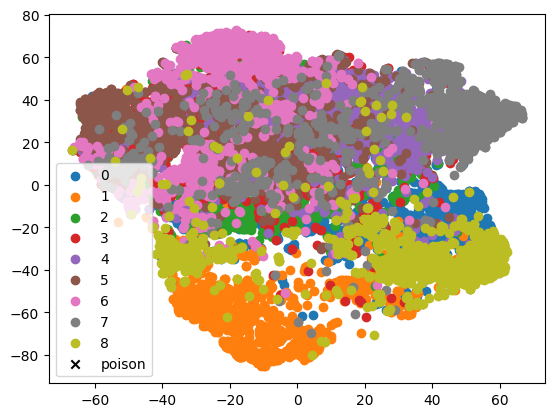

Epoch [21/300]	
	Step [0/391]	 Loss: 3.64595
	Step [50/391]	 Loss: 3.64348
	Step [100/391]	 Loss: 3.64316
	Step [150/391]	 Loss: 3.64087
	Step [200/391]	 Loss: 3.64732
	Step [250/391]	 Loss: 3.6383
	Step [300/391]	 Loss: 3.64544
	Step [350/391]	 Loss: 3.65282

	Training Loss: 3.6423639098701575
	Time Taken: 3.6232491532961526 minutes
Epoch [22/300]	
	Step [0/391]	 Loss: 3.63939
	Step [50/391]	 Loss: 3.63748
	Step [100/391]	 Loss: 3.63288
	Step [150/391]	 Loss: 3.63268
	Step [200/391]	 Loss: 3.64248
	Step [250/391]	 Loss: 3.64349
	Step [300/391]	 Loss: 3.64363
	Step [350/391]	 Loss: 3.66344

	Training Loss: 3.6413168925458512
	Time Taken: 3.6297829230626424 minutes
Epoch [23/300]	
	Step [0/391]	 Loss: 3.6376
	Step [50/391]	 Loss: 3.6468
	Step [100/391]	 Loss: 3.6378
	Step [150/391]	 Loss: 3.65169
	Step [200/391]	 Loss: 3.651
	Step [250/391]	 Loss: 3.63401
	Step [300/391]	 Loss: 3.63986
	Step [350/391]	 Loss: 3.64099

	Training Loss: 3.639924592679114
	Time Taken: 3.6158832192420958 minu

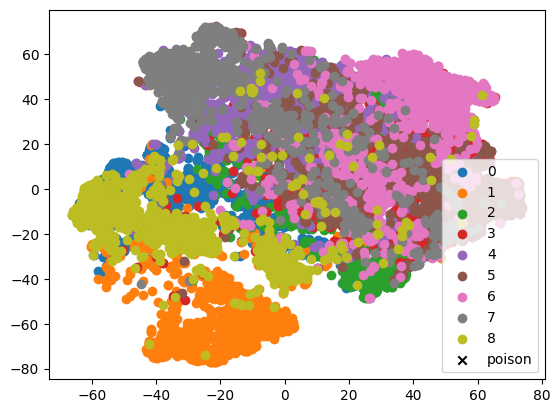

Epoch [31/300]	
	Step [0/391]	 Loss: 3.63537
	Step [50/391]	 Loss: 3.6375
	Step [100/391]	 Loss: 3.63495
	Step [150/391]	 Loss: 3.63631
	Step [200/391]	 Loss: 3.62801
	Step [250/391]	 Loss: 3.62703
	Step [300/391]	 Loss: 3.62862
	Step [350/391]	 Loss: 3.62531

	Training Loss: 3.631276612391557
	Time Taken: 3.6229657769203185 minutes
Epoch [32/300]	
	Step [0/391]	 Loss: 3.63153
	Step [50/391]	 Loss: 3.62931
	Step [100/391]	 Loss: 3.63149
	Step [150/391]	 Loss: 3.6221
	Step [200/391]	 Loss: 3.62718
	Step [250/391]	 Loss: 3.62387
	Step [300/391]	 Loss: 3.63174
	Step [350/391]	 Loss: 3.63336

	Training Loss: 3.6307978172741278
	Time Taken: 3.625816309452057 minutes
Epoch [33/300]	
	Step [0/391]	 Loss: 3.63615
	Step [50/391]	 Loss: 3.6307
	Step [100/391]	 Loss: 3.62875
	Step [150/391]	 Loss: 3.6237
	Step [200/391]	 Loss: 3.62896
	Step [250/391]	 Loss: 3.63123
	Step [300/391]	 Loss: 3.63487
	Step [350/391]	 Loss: 3.62789

	Training Loss: 3.6294141736481804
	Time Taken: 3.6190996368726096 min

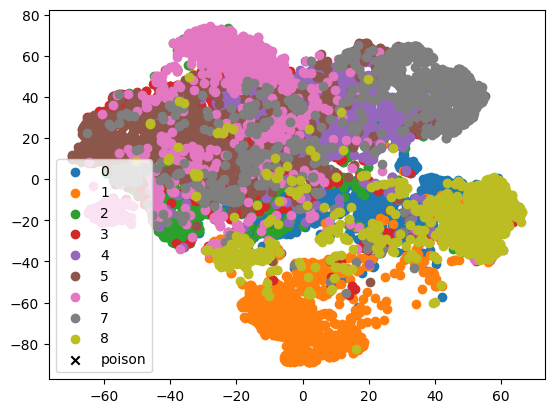

Epoch [41/300]	
	Step [0/391]	 Loss: 3.62611
	Step [50/391]	 Loss: 3.6266
	Step [100/391]	 Loss: 3.62433
	Step [150/391]	 Loss: 3.63556
	Step [200/391]	 Loss: 3.61982
	Step [250/391]	 Loss: 3.6276
	Step [300/391]	 Loss: 3.62019
	Step [350/391]	 Loss: 3.62838

	Training Loss: 3.6245886224614994
	Time Taken: 3.6293329278628033 minutes
Epoch [42/300]	
	Step [0/391]	 Loss: 3.6264
	Step [50/391]	 Loss: 3.62751
	Step [100/391]	 Loss: 3.61996
	Step [150/391]	 Loss: 3.63112
	Step [200/391]	 Loss: 3.62059
	Step [250/391]	 Loss: 3.62914
	Step [300/391]	 Loss: 3.61864
	Step [350/391]	 Loss: 3.61692

	Training Loss: 3.624069962660065
	Time Taken: 3.6334662715593975 minutes
Epoch [43/300]	
	Step [0/391]	 Loss: 3.62574
	Step [50/391]	 Loss: 3.62233
	Step [100/391]	 Loss: 3.62332
	Step [150/391]	 Loss: 3.62179
	Step [200/391]	 Loss: 3.62218
	Step [250/391]	 Loss: 3.62512
	Step [300/391]	 Loss: 3.6281
	Step [350/391]	 Loss: 3.62418

	Training Loss: 3.6236135923039274
	Time Taken: 3.627199637889862 min

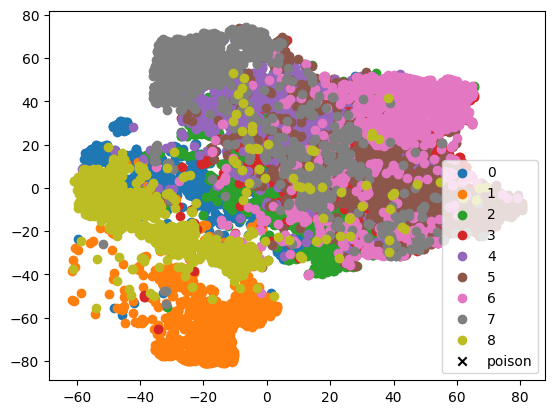

Epoch [51/300]	
	Step [0/391]	 Loss: 3.62476
	Step [50/391]	 Loss: 3.62538
	Step [100/391]	 Loss: 3.62126
	Step [150/391]	 Loss: 3.6121
	Step [200/391]	 Loss: 3.61446
	Step [250/391]	 Loss: 3.61616
	Step [300/391]	 Loss: 3.6233
	Step [350/391]	 Loss: 3.62628

	Training Loss: 3.61909786819497
	Time Taken: 3.626966647307078 minutes
Epoch [52/300]	
	Step [0/391]	 Loss: 3.61545
	Step [50/391]	 Loss: 3.6192
	Step [100/391]	 Loss: 3.61575
	Step [150/391]	 Loss: 3.62268
	Step [200/391]	 Loss: 3.62741
	Step [250/391]	 Loss: 3.62447
	Step [300/391]	 Loss: 3.6123
	Step [350/391]	 Loss: 3.61647

	Training Loss: 3.618846436595673
	Time Taken: 3.627999997138977 minutes
Epoch [53/300]	
	Step [0/391]	 Loss: 3.62299
	Step [50/391]	 Loss: 3.62076
	Step [100/391]	 Loss: 3.62289
	Step [150/391]	 Loss: 3.61488
	Step [200/391]	 Loss: 3.6107
	Step [250/391]	 Loss: 3.62377
	Step [300/391]	 Loss: 3.61697
	Step [350/391]	 Loss: 3.61804

	Training Loss: 3.6181701180880026
	Time Taken: 3.6182667136192324 minutes

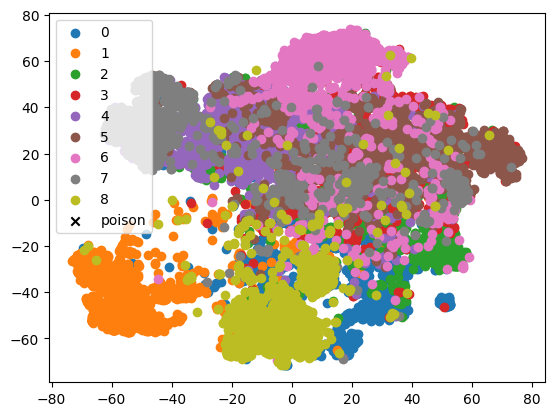

Epoch [61/300]	
	Step [0/391]	 Loss: 3.62089
	Step [50/391]	 Loss: 3.61937
	Step [100/391]	 Loss: 3.61795
	Step [150/391]	 Loss: 3.61973
	Step [200/391]	 Loss: 3.61808
	Step [250/391]	 Loss: 3.6134
	Step [300/391]	 Loss: 3.62221
	Step [350/391]	 Loss: 3.61426

	Training Loss: 3.615097484930092
	Time Taken: 3.6241166234016418 minutes
Epoch [62/300]	
	Step [0/391]	 Loss: 3.61523
	Step [50/391]	 Loss: 3.62498
	Step [100/391]	 Loss: 3.61752
	Step [150/391]	 Loss: 3.61756
	Step [200/391]	 Loss: 3.62703
	Step [250/391]	 Loss: 3.62584
	Step [300/391]	 Loss: 3.60961
	Step [350/391]	 Loss: 3.61155

	Training Loss: 3.615088746370867
	Time Taken: 3.6243333339691164 minutes
Epoch [63/300]	
	Step [0/391]	 Loss: 3.61261
	Step [50/391]	 Loss: 3.60848
	Step [100/391]	 Loss: 3.61456
	Step [150/391]	 Loss: 3.61561
	Step [200/391]	 Loss: 3.61299
	Step [250/391]	 Loss: 3.62079
	Step [300/391]	 Loss: 3.622
	Step [350/391]	 Loss: 3.61448

	Training Loss: 3.6149251174438946
	Time Taken: 3.617718780040741 min

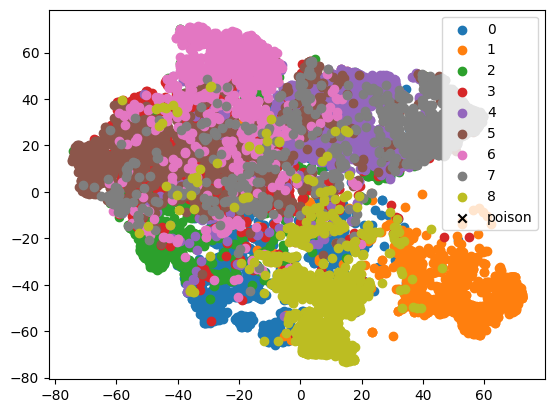

Epoch [71/300]	
	Step [0/391]	 Loss: 3.61077
	Step [50/391]	 Loss: 3.62549
	Step [100/391]	 Loss: 3.60525
	Step [150/391]	 Loss: 3.61292
	Step [200/391]	 Loss: 3.61053
	Step [250/391]	 Loss: 3.60991
	Step [300/391]	 Loss: 3.61624
	Step [350/391]	 Loss: 3.61354

	Training Loss: 3.612311510783632
	Time Taken: 3.6242433905601503 minutes
Epoch [72/300]	
	Step [0/391]	 Loss: 3.61234
	Step [50/391]	 Loss: 3.61598
	Step [100/391]	 Loss: 3.61238
	Step [150/391]	 Loss: 3.61193
	Step [200/391]	 Loss: 3.61428
	Step [250/391]	 Loss: 3.61104
	Step [300/391]	 Loss: 3.61
	Step [350/391]	 Loss: 3.61406

	Training Loss: 3.6119034595196813
	Time Taken: 3.621476912498474 minutes
Epoch [73/300]	
	Step [0/391]	 Loss: 3.61577
	Step [50/391]	 Loss: 3.62262
	Step [100/391]	 Loss: 3.61187
	Step [150/391]	 Loss: 3.61336
	Step [200/391]	 Loss: 3.61074
	Step [250/391]	 Loss: 3.61778
	Step [300/391]	 Loss: 3.62344
	Step [350/391]	 Loss: 3.6087

	Training Loss: 3.611586522568217
	Time Taken: 3.6124293406804404 minu

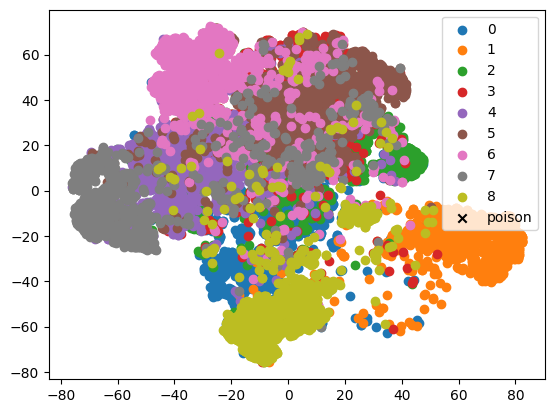

Epoch [81/300]	
	Step [0/391]	 Loss: 3.61365
	Step [50/391]	 Loss: 3.6086
	Step [100/391]	 Loss: 3.61734
	Step [150/391]	 Loss: 3.61529
	Step [200/391]	 Loss: 3.60677
	Step [250/391]	 Loss: 3.60758
	Step [300/391]	 Loss: 3.61066
	Step [350/391]	 Loss: 3.6061

	Training Loss: 3.6092759221411117
	Time Taken: 3.631367007891337 minutes
Epoch [82/300]	
	Step [0/391]	 Loss: 3.60973
	Step [50/391]	 Loss: 3.61124
	Step [100/391]	 Loss: 3.60852
	Step [150/391]	 Loss: 3.60905
	Step [200/391]	 Loss: 3.61225
	Step [250/391]	 Loss: 3.60806
	Step [300/391]	 Loss: 3.60928
	Step [350/391]	 Loss: 3.60329

	Training Loss: 3.609563161649972
	Time Taken: 3.619061283270518 minutes
Epoch [83/300]	
	Step [0/391]	 Loss: 3.61125
	Step [50/391]	 Loss: 3.61944
	Step [100/391]	 Loss: 3.6078
	Step [150/391]	 Loss: 3.60569
	Step [200/391]	 Loss: 3.61714
	Step [250/391]	 Loss: 3.60616
	Step [300/391]	 Loss: 3.6159
	Step [350/391]	 Loss: 3.60744

	Training Loss: 3.608930188371702
	Time Taken: 3.616787815093994 minute

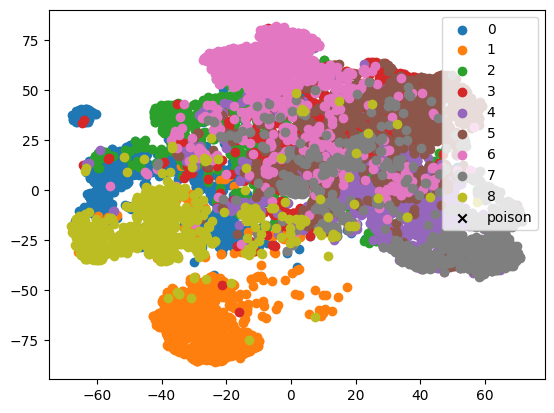

Epoch [91/300]	
	Step [0/391]	 Loss: 3.60719
	Step [50/391]	 Loss: 3.60299
	Step [100/391]	 Loss: 3.60404
	Step [150/391]	 Loss: 3.6145
	Step [200/391]	 Loss: 3.60711
	Step [250/391]	 Loss: 3.61186
	Step [300/391]	 Loss: 3.60896
	Step [350/391]	 Loss: 3.61179

	Training Loss: 3.607415074887483
	Time Taken: 3.629506997267405 minutes
Epoch [92/300]	
	Step [0/391]	 Loss: 3.60984
	Step [50/391]	 Loss: 3.60733
	Step [100/391]	 Loss: 3.60283
	Step [150/391]	 Loss: 3.6102
	Step [200/391]	 Loss: 3.60905
	Step [250/391]	 Loss: 3.60293
	Step [300/391]	 Loss: 3.60173
	Step [350/391]	 Loss: 3.61252

	Training Loss: 3.606967480896074
	Time Taken: 3.630082833766937 minutes
Epoch [93/300]	
	Step [0/391]	 Loss: 3.61052
	Step [50/391]	 Loss: 3.60688
	Step [100/391]	 Loss: 3.60863
	Step [150/391]	 Loss: 3.61196
	Step [200/391]	 Loss: 3.61516
	Step [250/391]	 Loss: 3.60632
	Step [300/391]	 Loss: 3.61618
	Step [350/391]	 Loss: 3.60628

	Training Loss: 3.6065398256492127
	Time Taken: 3.6206496636072796 min

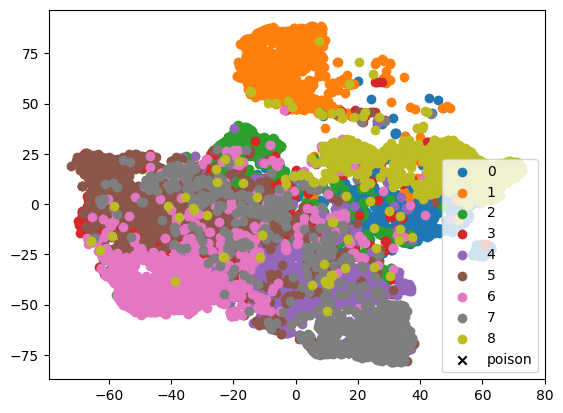

Epoch [101/300]	
	Step [0/391]	 Loss: 3.60868
	Step [50/391]	 Loss: 3.60428
	Step [100/391]	 Loss: 3.60802
	Step [150/391]	 Loss: 3.60164
	Step [200/391]	 Loss: 3.6083
	Step [250/391]	 Loss: 3.60491
	Step [300/391]	 Loss: 3.6132
	Step [350/391]	 Loss: 3.60659

	Training Loss: 3.605058199914215
	Time Taken: 3.6129229148228963 minutes
Epoch [102/300]	
	Step [0/391]	 Loss: 3.60414
	Step [50/391]	 Loss: 3.61511
	Step [100/391]	 Loss: 3.60647
	Step [150/391]	 Loss: 3.61146
	Step [200/391]	 Loss: 3.60649
	Step [250/391]	 Loss: 3.60553
	Step [300/391]	 Loss: 3.60589
	Step [350/391]	 Loss: 3.60256

	Training Loss: 3.604929472784252
	Time Taken: 3.619789524873098 minutes
Epoch [103/300]	
	Step [0/391]	 Loss: 3.60417
	Step [50/391]	 Loss: 3.60604
	Step [100/391]	 Loss: 3.60564
	Step [150/391]	 Loss: 3.60883
	Step [200/391]	 Loss: 3.60304
	Step [250/391]	 Loss: 3.60613
	Step [300/391]	 Loss: 3.60782
	Step [350/391]	 Loss: 3.60146

	Training Loss: 3.6045338351403355
	Time Taken: 3.6159729321797687

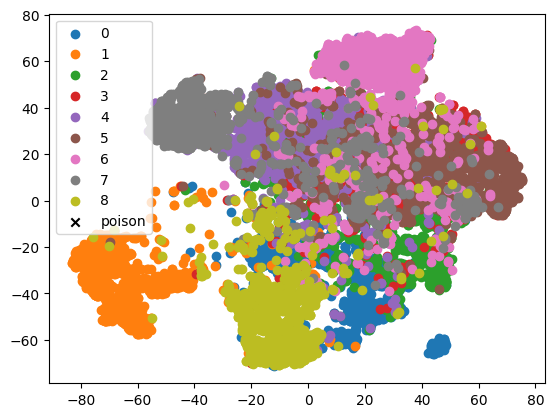

Epoch [111/300]	
	Step [0/391]	 Loss: 3.60324
	Step [50/391]	 Loss: 3.60413
	Step [100/391]	 Loss: 3.6038
	Step [150/391]	 Loss: 3.60903
	Step [200/391]	 Loss: 3.59978
	Step [250/391]	 Loss: 3.60814
	Step [300/391]	 Loss: 3.60697
	Step [350/391]	 Loss: 3.60397

	Training Loss: 3.603538766236561
	Time Taken: 3.7298838019371034 minutes
Epoch [112/300]	
	Step [0/391]	 Loss: 3.60566
	Step [50/391]	 Loss: 3.60488
	Step [100/391]	 Loss: 3.6086
	Step [150/391]	 Loss: 3.60804
	Step [200/391]	 Loss: 3.59685
	Step [250/391]	 Loss: 3.60046
	Step [300/391]	 Loss: 3.60593
	Step [350/391]	 Loss: 3.60746

	Training Loss: 3.602923021901904
	Time Taken: 3.732067171732585 minutes
Epoch [113/300]	
	Step [0/391]	 Loss: 3.59961
	Step [50/391]	 Loss: 3.60399
	Step [100/391]	 Loss: 3.60105
	Step [150/391]	 Loss: 3.59838
	Step [200/391]	 Loss: 3.60603
	Step [250/391]	 Loss: 3.59849
	Step [300/391]	 Loss: 3.60351
	Step [350/391]	 Loss: 3.60465

	Training Loss: 3.6027616728907046
	Time Taken: 3.708634388446808 

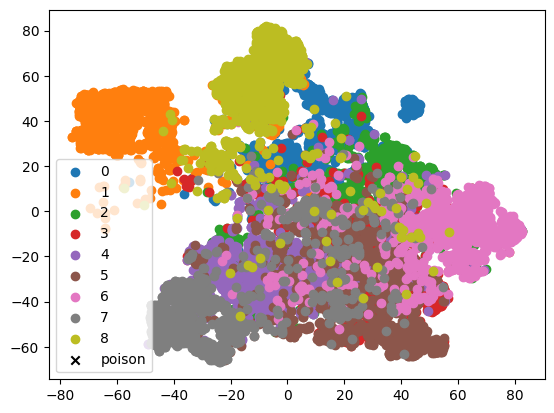

Epoch [121/300]	
	Step [0/391]	 Loss: 3.60783
	Step [50/391]	 Loss: 3.6024
	Step [100/391]	 Loss: 3.61116
	Step [150/391]	 Loss: 3.59759
	Step [200/391]	 Loss: 3.59994
	Step [250/391]	 Loss: 3.60751
	Step [300/391]	 Loss: 3.60699
	Step [350/391]	 Loss: 3.60244

	Training Loss: 3.601517596208226
	Time Taken: 3.722822701931 minutes
Epoch [122/300]	
	Step [0/391]	 Loss: 3.60191
	Step [50/391]	 Loss: 3.59953
	Step [100/391]	 Loss: 3.60348
	Step [150/391]	 Loss: 3.60227
	Step [200/391]	 Loss: 3.60119
	Step [250/391]	 Loss: 3.59524
	Step [300/391]	 Loss: 3.60586
	Step [350/391]	 Loss: 3.59689

	Training Loss: 3.601398585092686
	Time Taken: 3.719223229090373 minutes
Epoch [123/300]	
	Step [0/391]	 Loss: 3.60801
	Step [50/391]	 Loss: 3.59729
	Step [100/391]	 Loss: 3.59897
	Step [150/391]	 Loss: 3.59784
	Step [200/391]	 Loss: 3.60387
	Step [250/391]	 Loss: 3.59987
	Step [300/391]	 Loss: 3.60002
	Step [350/391]	 Loss: 3.59945

	Training Loss: 3.6010934288239542
	Time Taken: 3.714641006787618 min

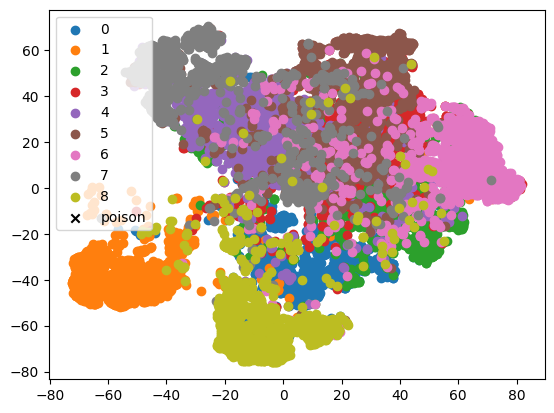

Epoch [131/300]	
	Step [0/391]	 Loss: 3.60175
	Step [50/391]	 Loss: 3.59934
	Step [100/391]	 Loss: 3.60004
	Step [150/391]	 Loss: 3.60084
	Step [200/391]	 Loss: 3.5946
	Step [250/391]	 Loss: 3.59586
	Step [300/391]	 Loss: 3.6015
	Step [350/391]	 Loss: 3.59904

	Training Loss: 3.59994907025486
	Time Taken: 3.7332097848256427 minutes
Epoch [132/300]	
	Step [0/391]	 Loss: 3.59838
	Step [50/391]	 Loss: 3.60379
	Step [100/391]	 Loss: 3.59789
	Step [150/391]	 Loss: 3.60004
	Step [200/391]	 Loss: 3.60499
	Step [250/391]	 Loss: 3.60123
	Step [300/391]	 Loss: 3.61069
	Step [350/391]	 Loss: 3.59559

	Training Loss: 3.599942768931084
	Time Taken: 3.726477070649465 minutes
Epoch [133/300]	
	Step [0/391]	 Loss: 3.59802
	Step [50/391]	 Loss: 3.59918
	Step [100/391]	 Loss: 3.60565
	Step [150/391]	 Loss: 3.59962
	Step [200/391]	 Loss: 3.60853
	Step [250/391]	 Loss: 3.598
	Step [300/391]	 Loss: 3.60147
	Step [350/391]	 Loss: 3.59737

	Training Loss: 3.5995071361131985
	Time Taken: 3.7125277717908225 mi

KeyboardInterrupt: 

In [14]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, f"NEW-SimCLR-{epoch}.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, f"NEW-SimCLR.pt-{epoch}")